# Using Tabula Sapiens as a reference for annotating new datasets

In [1]:
import os, sys

sys.path.insert(0, '../../PopV')
import popv
import anndata
import numpy as np
import scanpy as sc
from scanpy.plotting import palettes
sys.path.insert(-1, '../..')
import _utils

2023-03-11 14:25:11.750218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 14:25:11.896934: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-11 14:25:12.496093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-03-11 14:25:12.496141: W tensorflow/compiler/xla/stream_executor/platf

In [2]:
popv.__file__

'/data/extra_files/galen_dropbox_figures/can_reproducibility/lung_models/lung_annotation/../../PopV/popv/__init__.py'

# Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [3]:
query_adata = sc.read('lung_query_construction/LCA.h5ad')
query_adata.obs_names_make_unique()
query_adata.var_names = query_adata.var_names.str.upper()
query_adata = query_adata[~query_adata.obs['sample'].str.contains("blood")].copy()
# query_adata = query_adata[np.random.choice(query_adata.obs_names, 1000, replace=False)]

In [4]:
del query_adata.uns
del query_adata.var
del query_adata.raw
query_adata.write('lung_query_construction/sub_LCA.h5ad')

# Step 3 (User Action Required): Setting Up Annotation Parameters 

Here is where you set the parameters for the automated annotation.

Arguments:
- **tissue:** Tabula Sapiens tissue to annotate your data with. Available tissues: ["Bladder", "Blood", "Bone_Marrow", "Kidney", "Large_Intestine", "Lung","Lymph_Node", "Pancreas", "Small_Intestine", "Spleen", "Thymus","Trachea", "Vasculature"]
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction. 
- **algorithms:** these are the methods to run. By default, will run all methods.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred",


Lesser used parameters
- **query_labels_key**: scANVI has the option to use labeled cells in the query dataset during training. To use some prelabeled cells from the query dataset, set `query_labels_key` to the corresponding key in `query_adata.obs`
- **unknown_celltype_label**: If `query_labels_key` is not None, will treat everything not labeled `unknown_celltype_label` as a labeled cell

In [5]:
""" 
tissue options: 
['Bladder','Blood','Bone_Marrow','Fat',
'Heart','Kidney','Large_Intestine','Liver',
'Lung','Lymph_Node','Mammary','Muscle',
'Pancreas','Prostate','Salivary Gland',
'Skin','Small_Intestine','Spleen',
'Thymus','Trachea','Vasculature']
"""
output_folder = 'annotation'
tissue = 'Lung'
save_folder = f'{output_folder}/popv_results'

query_batch_key = 'donor_assay'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Step 4: Downloading Reference Data and Pretrained Models
No more user input required! Just run all the following code blocks.

**NOTE: PopV has only been evaluated with the Lung/Thymus/Lymph_Node as a reference dataset. Different tissues have different annotation quality and the Tabula sapiens community is currently actively improving the annotation quality. We strongly expect improvement of cell annotation when the updated annotation is released. Upon release the Zenodo repository will be updated.**

In [6]:
import requests
res = requests.get("https://zenodo.org/api/records/7587774")
tissue_download_path = {ind['key'][3:-14]:ind['links']['self'] for ind in res.json()['files']}

In [7]:
refdata_url = tissue_download_path[tissue]
output_fn = f'{output_folder}/TS_{tissue}.h5ad'
if not os.path.exists(output_fn):
    !wget -O $output_fn $refdata_url

In [8]:
output_fn = f'{output_folder}/TS_{tissue}.h5ad'
# read in the reference dataset
ref_adata = sc.read_h5ad(output_fn)
# ref_adata = ref_adata[np.random.choice(ref_adata.obs_names, 5000, replace=False)]

In [9]:
ref_adata.obs['cell_ontology_class'] = ref_adata.obs['cell_ontology_class'].astype(str)
ref_adata.obs.loc[ref_adata.obs['free_annotation']=='capillary aerocyte', 'cell_ontology_class'] = 'alveolar capillary type 2 endothelial cell'
ref_adata.obs['cell_ontology_class'] = ref_adata.obs['cell_ontology_class'].astype('category')

### Setup reference data

In [10]:
# Following parameters are specific to Tabula Sapiens dataset and contain the annotated cell-type and the batch_key that are corrected for during model training.
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [11]:
min_celltype_size = np.min(ref_adata.obs.groupby(ref_labels_key).size())
n_samples_per_label = np.max((min_celltype_size, 500))

### Preprocess query with ref dataset


In [12]:
from popv.preprocessing import Process_Query

adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        cl_obo_folder='../../PopV/ontology/',
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'{output_folder}/pretrained_models/',
        prediction_mode='retrain', # 'fast' mode gives fast results (does not include BBKNN and Scanorama and makes more inaccurate errors)
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata

Sampling 500 per label


In [13]:
adata

AnnData object with n_obs × n_vars = 105322 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'paper_annotation', 'sample', '_dataset', 'n_counts'
    var: 'n_counts', 'highly_variable', 'mean', 'std'
    uns: 'Filtered_cells', 'log1p', 'unknown_celltype_label', '_pretrained_scvi_path', '_save_path_trained_models', '_prediction_mode', '_cl_obo_file', '_cl_ontology_file', '_nlp_emb_file', '_use_gpu', '_compute_embedding', '_return_probabilities', 'prediction_keys'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'scvi_counts', 'scaled_counts'

# Step 5: Run Automated Cell Annotation Methods
No user action required. 

Your results will be saved to the folder you provided as **save_folder**.

All results are stored in adata.obs
- The column `popv_prediction` contains the end popv prediction. 
- `popv_prediction_score` contains the score for the popv_prediction, which is a measure of the number of methods that agreed with the resulting prediction. We use the cell ontology when aggregating results.
- We also include the majority vote, which simply takes the celltype that was most often predicted by the individual methods.

In [14]:
from popv.annotation import annotate_data
annotate_data(adata, save_path=f'{output_folder}/popv_output_cuml')

Saving celltypist results to adata.obs["popv_celltypist_prediction"]
🍳 Preparing data before training
✂️ 9 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 105322 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 3991 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!
Integrating data with bbknn
Saving knn on bbknn results to adata.obs["popv_knn_on_bbknn_prediction"]
Saving UMAP of bbknn results to adata.obs["X_bbknn_umap_popv"]
Integrating data with scanorama


Found 4000 genes among all datasets
[[0.00000000e+00 1.45287356e-01 1.01596517e-02 1.94712644e-01
  1.66481687e-02 1.21839080e-02 2.95040804e-02 3.04506699e-03
  2.62068966e-02 5.04540868e-04 9.65517241e-03 0.00000000e+00
  9.65517241e-03 7.74593338e-04 0.00000000e+00 7.81609195e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.51378810e-01 3.07053701e-01
  1.05438402e-01 6.53907496e-02 1.11738858e-01 4.87210719e-02
  8.41128968e-02 1.10998991e-02 7.29991205e-02 1.76470588e-02
  2.38266571e-02 1.23934934e-02 1.61001789e-02 9.97041039e-02
  1.00000000e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.09579100e-02
  4.05105438e-01 1.84325109e-01 3.49782293e-01 2.30769231e-01
  2.00290276e-01 3.51233672e-01 1.79970972e-01 2.69956459e-01
  8.85341074e-02 1.68359942e-01 1.62790698e-01 1.33526851e-01
  8.25000000e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.34961154e-01 1.14832536e-01 1.55053358e-01 3.77588307e-02
  7.33817126e-02 2.52270434e-03 6.91436865

Saving knn on scanorama results to adata.obs["popv_knn_on_scanorama_prediction"]
Saving UMAP of scanorama results to adata.obs["X_umap_scanorma_popv"]
Integrating data with scvi
Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Training scvi offline.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Epoch 38/38: 100%|██████████| 38/38 [05:04<00:00,  4.73s/it, loss=1.66e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=38` reached.


Epoch 38/38: 100%|██████████| 38/38 [05:04<00:00,  8.02s/it, loss=1.66e+03, v_num=1]


Saving knn on scvi results to adata.obs["popv_knn_on_scvi_prediction"]
Saving UMAP of scvi results to adata.obs["X_scvi_umap_popv"]
Computing Onclass. Storing prediction in adata.obs["popv_onclass_prediction"]
2023-03-11 14:50:12.493909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 14:50:12.541861: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-11 14:50:12.632660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), 

Training cost after epoch 1: loss:5.118313 acc: 0.963 auc: 1.000 auprc: 0.972
Training cost after epoch 2: loss:2.402122 acc: 0.983 auc: 1.000 auprc: 0.997
Training cost after epoch 3: loss:1.593945 acc: 0.994 auc: 1.000 auprc: 1.000
Training cost after epoch 4: loss:1.139554 acc: 0.992 auc: 1.000 auprc: 1.000
Training cost after epoch 5: loss:0.833845 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 6: loss:0.621959 acc: 0.997 auc: 1.000 auprc: 1.000
Training cost after epoch 7: loss:0.473392 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 8: loss:0.371027 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 9: loss:0.302149 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 10: loss:0.251651 acc: 0.998 auc: 1.000 auprc: 1.000
Training cost after epoch 11: loss:0.213096 acc: 0.995 auc: 1.000 auprc: 1.000
Training cost after epoch 12: loss:0.188776 acc: 0.994 auc: 1.000 auprc: 1.000
Training cost after epoch 13: loss:0.176243 acc: 0.989 auc: 1

Computing random forest classifier. Storing prediction in adata.obs["popv_rf_prediction"]
Integrating data with scANVI


INFO     File annotation/pretrained_models//scvi/model.pt already downloaded                                       
INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [02:36<00:00,  7.47s/it, loss=1.79e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:36<00:00,  7.83s/it, loss=1.79e+03, v_num=1]

Saving scanvi label prediction to adata.obs["popv_scanvi_prediction"]


Saving UMAP of scanvi results to adata.obs["X_scanvi_umap_popv"]
Computing support vector machine. Storing prediction in adata.obs["popv_svm_prediction"]
Using predictions ['popv_celltypist_prediction', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scvi_prediction', 'popv_onclass_prediction', 'popv_rf_prediction', 'popv_scanvi_prediction', 'popv_svm_prediction'] for PopV consensus
Predictions saved to annotation/popv_output/predictions.csv


In [15]:
# Optional: save the full anndata will all objects
adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

... storing 'donor_id' as categorical
... storing 'assay' as categorical
... storing 'donor_assay' as categorical
... storing '_batch_annotation' as categorical
... storing '_labels_annotation' as categorical
... storing 'popv_knn_on_bbknn_prediction' as categorical
... storing 'popv_knn_on_scanorama_prediction' as categorical
... storing 'popv_knn_on_scvi_prediction' as categorical
... storing '_labels_annotation_cell_ontology_id' as categorical
... storing 'popv_onclass_prediction' as categorical
... storing 'popv_onclass_seen' as categorical
... storing 'popv_rf_prediction' as categorical
... storing 'popv_scanvi_prediction' as categorical
... storing 'popv_svm_prediction' as categorical
... storing 'popv_majority_vote_prediction' as categorical
... storing 'popv_prediction' as categorical
... storing 'popv_parent' as categorical


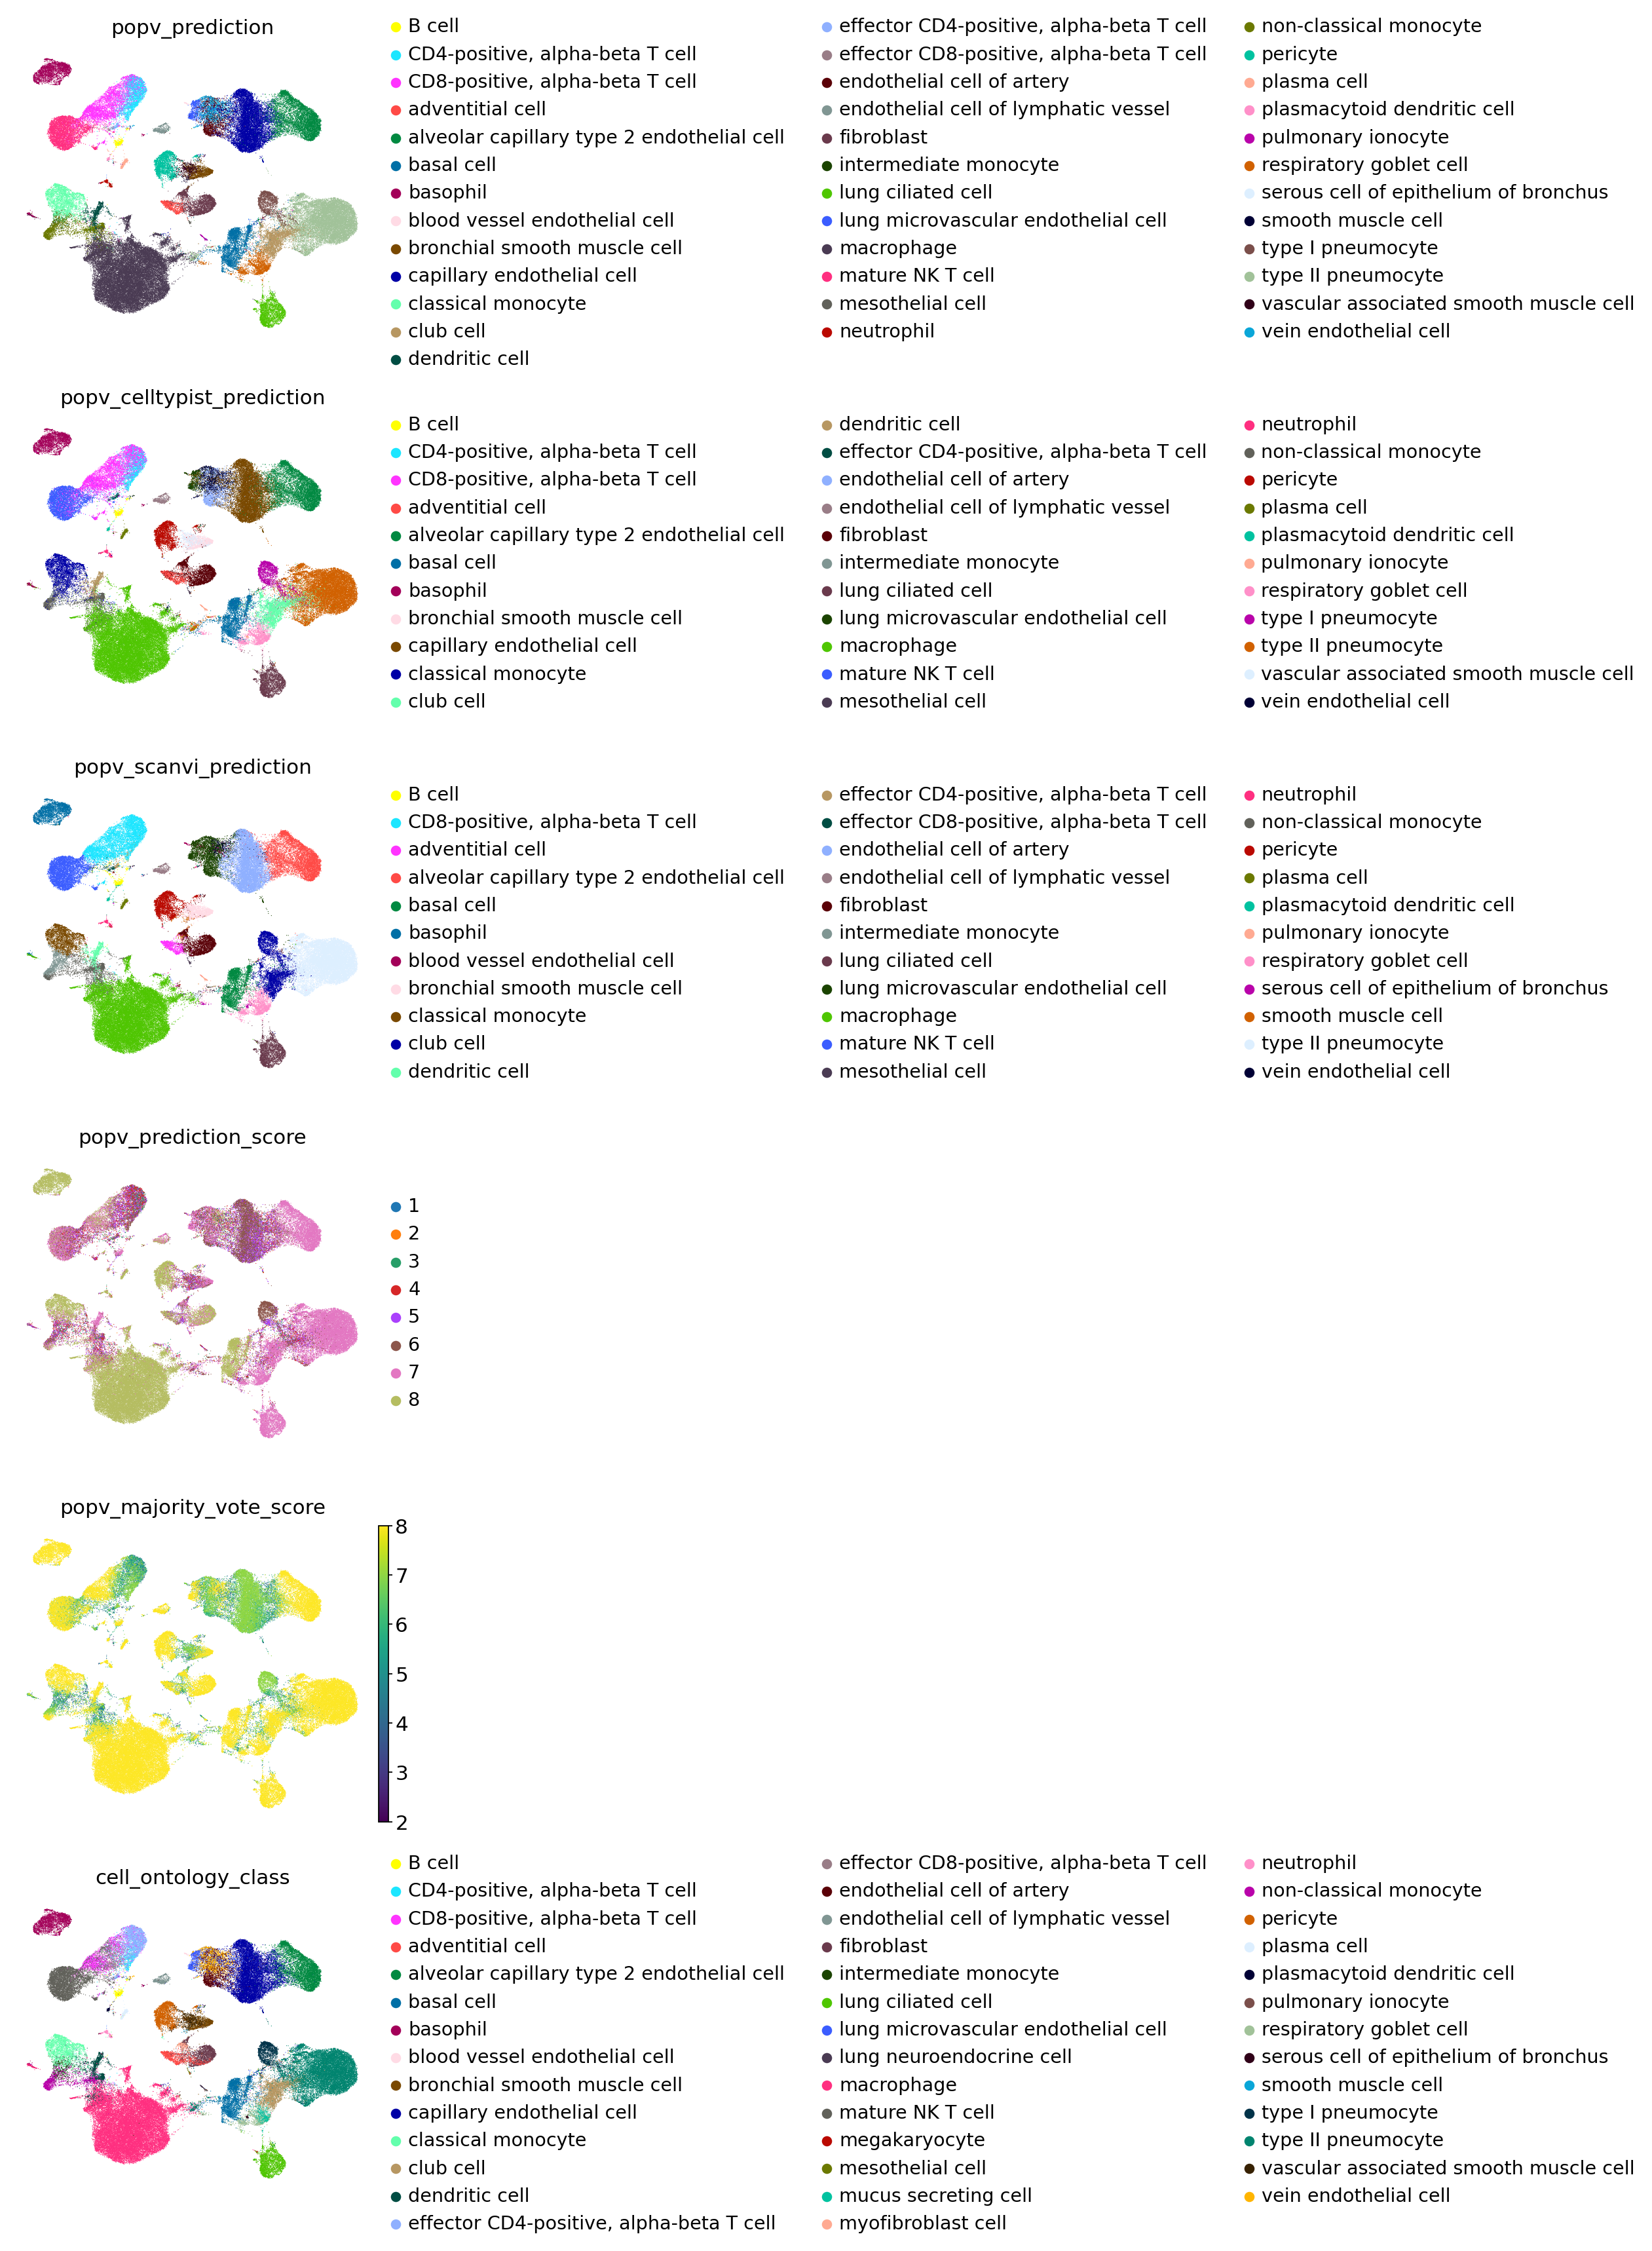

In [30]:
adata.obsm['X_umap'] = adata.obsm['X_scanvi_umap_popv']

sc.pl.umap(adata,
           color=['popv_prediction', 'popv_celltypist_prediction', 'popv_scanvi_prediction', 'popv_prediction_score', 'popv_majority_vote_score', 'cell_ontology_class'], ncols=1)

In [33]:
adata

AnnData object with n_obs × n_vars = 105322 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'paper_annotation', 'sample', '_dataset', 'n_counts', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanorama_prediction_probabilities', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', 'popv_knn_on_scvi_prediction_probabilities', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_onclass_seen', 'popv_onclass_prediction_probabilities', 'popv_onclass_seen_probabilities', 'popv_rf_prediction', 'popv_rf_prediction_probabilities

In [41]:
adata[adata.obs['popv_majority_vote_prediction'] != adata.obs['popv_prediction']].obs[['cell_ontology_class', 'popv_majority_vote_score', 'popv_majority_vote_prediction', 'popv_prediction', 'popv_onclass_prediction', 'popv_onclass_seen']].drop_duplicates()

cell_ontology_class  \
TTTACTGGTACAAGCG_TSP14_Lung_Proximal_10X_1_1                          adventitial cell   
GCGTGCAAGACTTGTC_TSP14_Lung_Proximal_10X_1_1  effector CD8-positive, alpha-beta T cell   
GATTTCTTCTCGTCAC_TSP14_Lung_Proximal_10X_1_1                        smooth muscle cell   
TAGACCAGTGATAGAT_TSP14_Lung_NA_10X_2_1                              type II pneumocyte   
GTCACGGAGCCGTTGC_TSP14_Lung_Distal_10X_1_1    effector CD4-positive, alpha-beta T cell   
...                                                                                ...   
P3_3_CACTCCATCTTGAGGT                                          respiratory goblet cell   
P3_3_ACGGCCAGTCGATTGT                                         lung neuroendocrine cell   
P3_2_TTTACTGCAAGCGTAG                                                       fibroblast   
F22_B003269.gencode.vH29                                              mature NK T cell   
L2_B002460.gencode.vH29                                     capillary endothelial cell   

                                              popv_majority_vote_score  \
TTTACTGGTACAAGCG_TSP14_Lung_Proximal_10X_1_1                         4   
GCGTGCAAGACTTGTC_TSP14_Lung_Proximal_10X_1_1                         3   
GATTTCTTCTCGTCAC_TSP14_Lung_Proximal_10X_1_1                         5   
TAGACCAGTGATAGAT_TSP14_Lung_NA_10X_2_1                               4   
GTCACGGAGCCGTTGC_TSP14_Lung_Distal_10X_1_1                           4   
...                                                                ...   
P3_3_CACTCCATCTTGAGGT                                                3   
P3_3_ACGGCCAGTCGATTGT                                                4   
P3_2_TTTACTGCAAGCGTAG                                                3   
F22_B003269.gencode.vH29                                             2   
L2_B002460.gencode.vH29                                              2   

                                                         popv_majority_vote_prediction  \
TTTACTGGTACAAGCG_TSP14_Lung_Proximal_10X_1_1                          adventitial cell   
GCGTGCAAGACTTGTC_TSP14_Lung_Proximal_10X_1_1  effector CD8-positive, alpha-beta T cell   
GATTTCTTCTCGTCAC_TSP14_Lung_Proximal_10X_1_1                                fibroblast   
TAGACCAGTGATAGAT_TSP14_Lung_NA_10X_2_1                              type II pneumocyte   
GTCACGGAGCCGTTGC_TSP14_Lung_Distal_10X_1_1    effector CD4-positive, alpha-beta T cell   
...                                                                                ...   
P3_3_CACTCCATCTTGAGGT                                                       basal cell   
P3_3_ACGGCCAGTCGATTGT                                                        club cell   
P3_2_TTTACTGCAAGCGTAG                                                       fibroblast   
F22_B003269.gencode.vH29                                                   plasma cell   
L2_B002460.gencode.vH29                                  blood vessel endothelial cell   

                                                                  popv_prediction  \
TTTACTGGTACAAGCG_TSP14_Lung_Proximal_10X_1_1                           fibroblast   
GCGTGCAAGACTTGTC_TSP14_Lung_Proximal_10X_1_1                     mature NK T cell   
GATTTCTTCTCGTCAC_TSP14_Lung_Proximal_10X_1_1                   smooth muscle cell   
TAGACCAGTGATAGAT_TSP14_Lung_NA_10X_2_1                          type I pneumocyte   
GTCACGGAGCCGTTGC_TSP14_Lung_Distal_10X_1_1        CD4-positive, alpha-beta T cell   
...                                                                           ...   
P3_3_CACTCCATCTTGAGGT                                     respiratory goblet cell   
P3_3_ACGGCCAGTCGATTGT                                          pulmonary ionocyte   
P3_2_TTTACTGCAAGCGTAG                                          smooth muscle cell   
F22_B003269.gencode.vH29                          CD8-positive, alpha-beta T cell   
L2_B002460.gencode.vH29                       lung microvascular endothelial cell

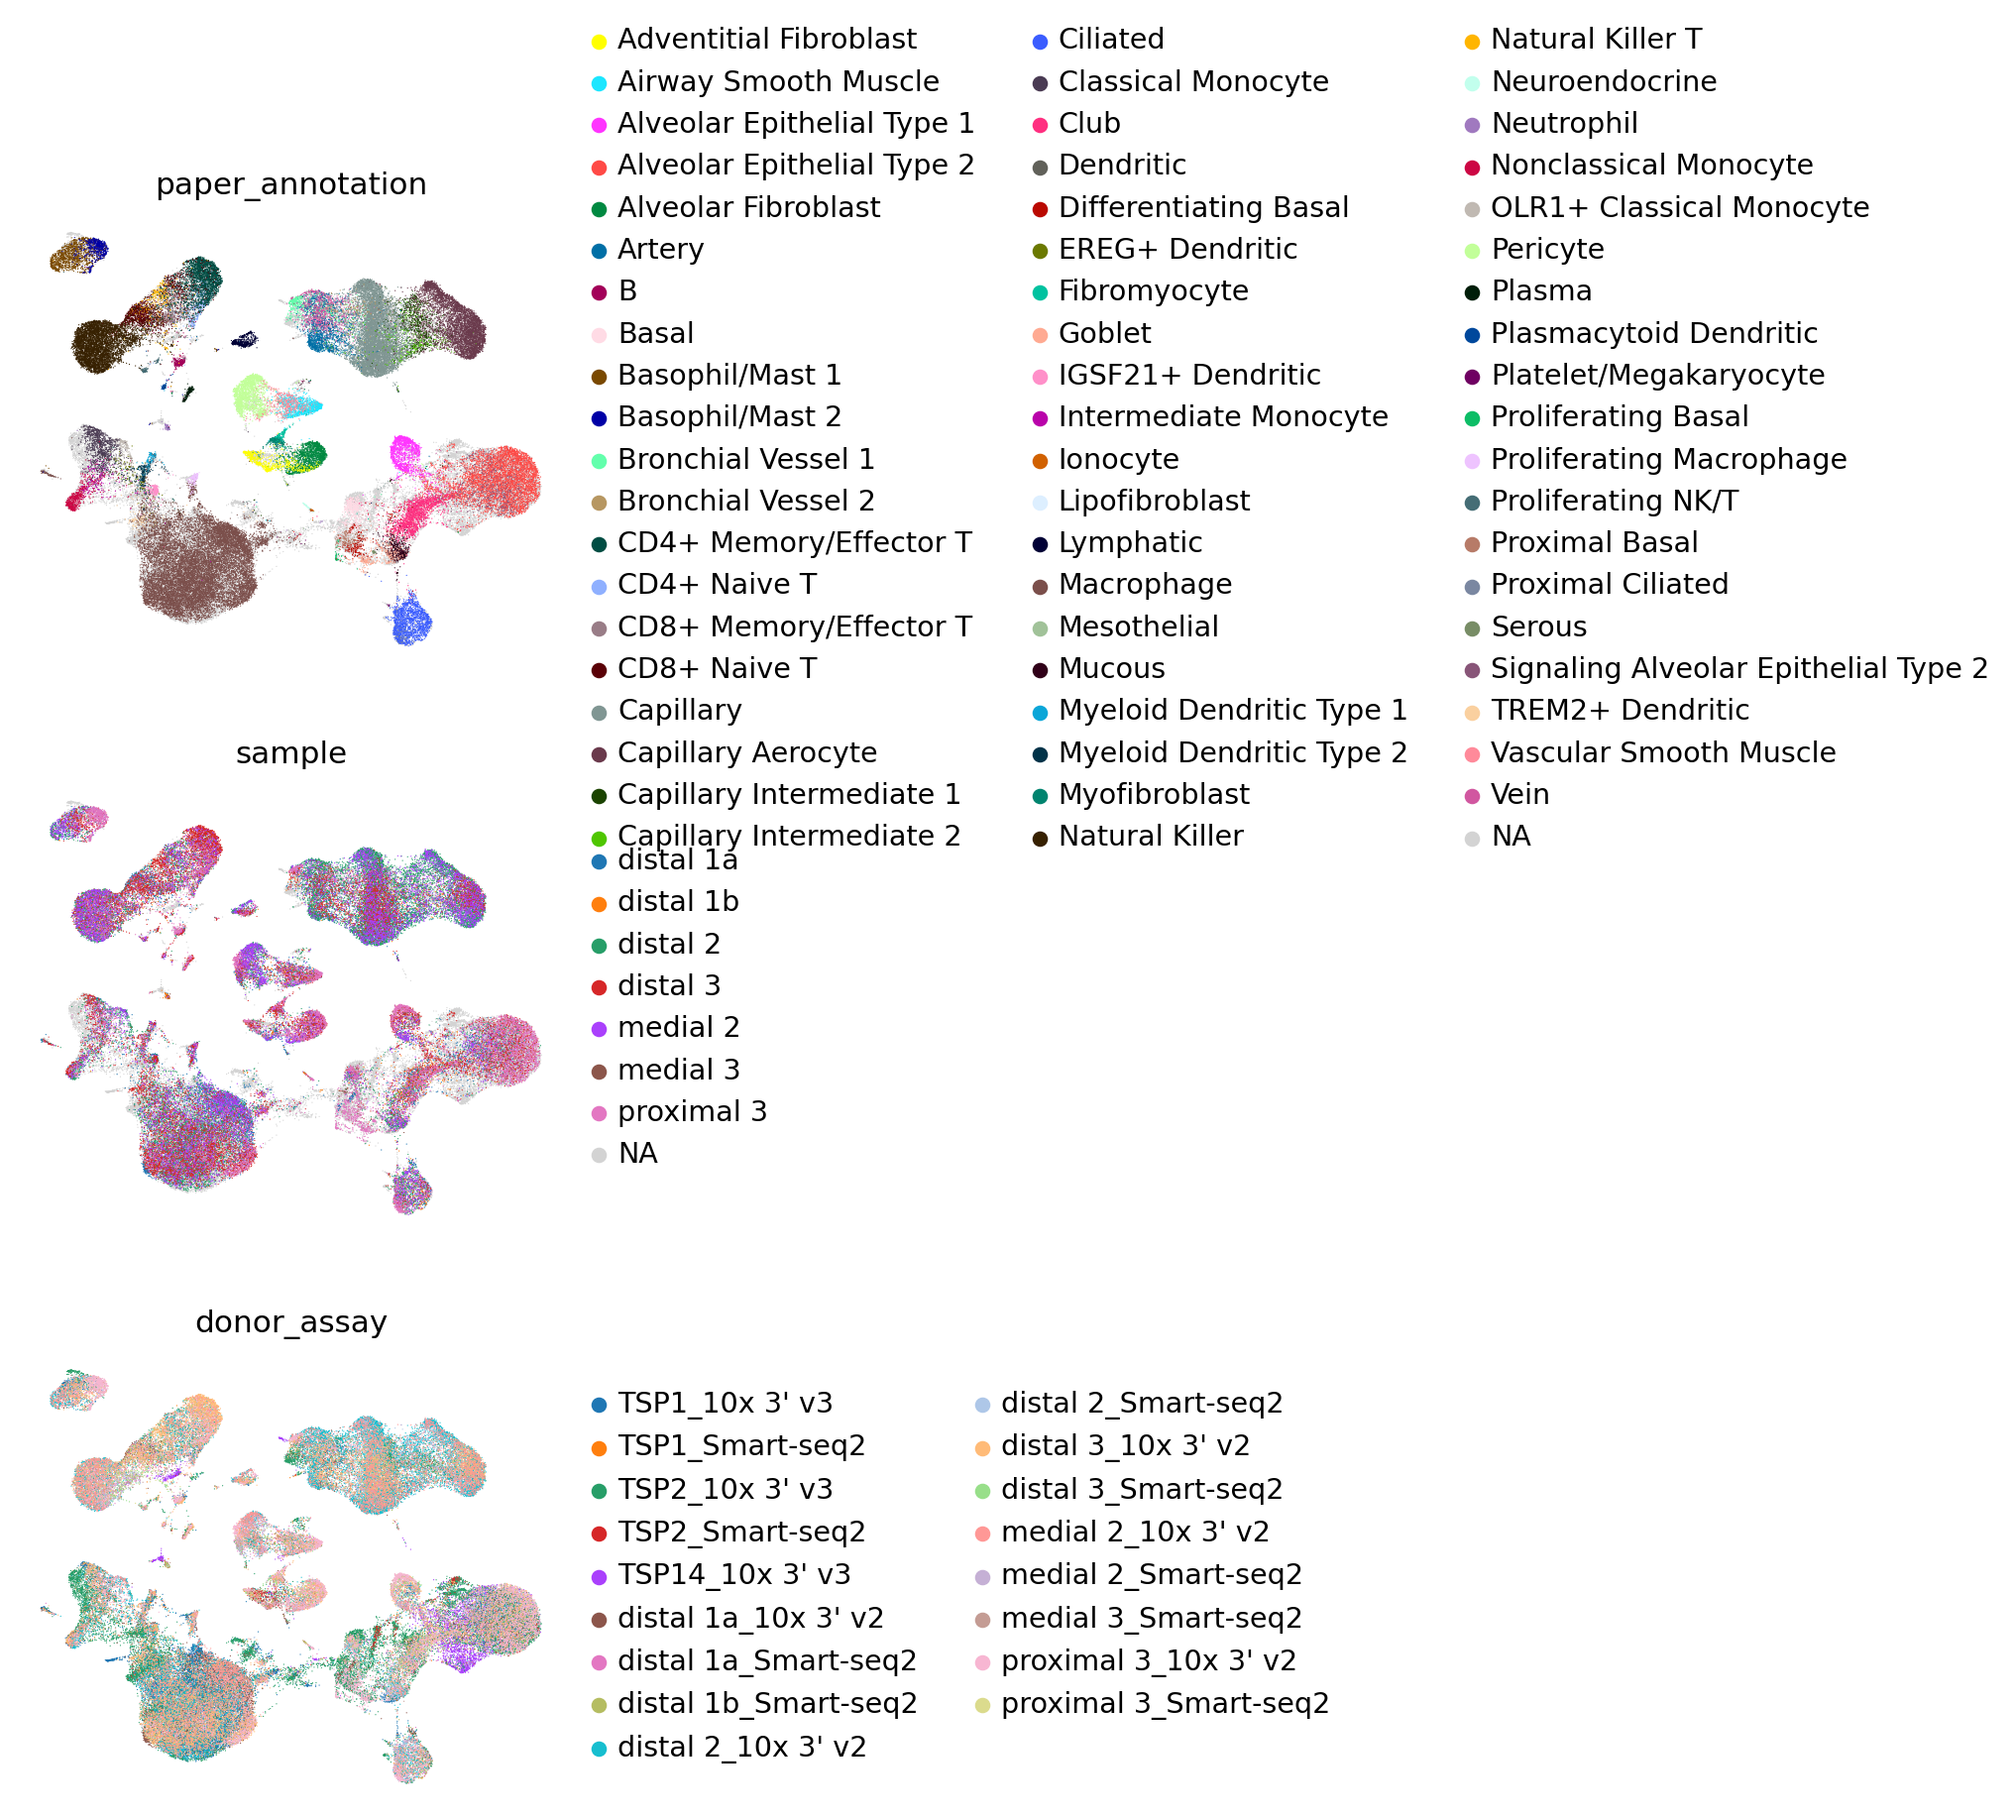

In [17]:
sc.pl.umap(
    adata, color=['paper_annotation', 'sample', 'donor_assay'], ncols=1)

# Step 6: Summary Statistics

In [18]:
adata

AnnData object with n_obs × n_vars = 105322 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'paper_annotation', 'sample', '_dataset', 'n_counts', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanorama_prediction_probabilities', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', 'popv_knn_on_scvi_prediction_probabilities', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_onclass_seen', 'popv_onclass_prediction_probabilities', 'popv_onclass_seen_probabilities', 'popv_rf_prediction', 'popv_rf_prediction_probabilities

In [ ]:
popv.visualization.make_agreement_plots(adata[adata.obs['_dataset']=='ref'], popv_prediction_key='cell_ontology_class', prediction_keys=['popv_prediction'], save_folder=output_folder)

In [ ]:
popv.visualization.make_agreement_plots(adata[adata.obs['_dataset']=='query'], popv_prediction_key='cell_ontology_class', prediction_keys=['popv_prediction'], save_folder=output_folder)

In [ ]:
popv.visualization.make_agreement_plots(adata[adata.obs['_dataset']=='query'], prediction_keys=adata.uns['prediction_keys'] + ['popv_onclass_seen'], save_folder=save_folder)

In [22]:
adata

AnnData object with n_obs × n_vars = 105322 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'paper_annotation', 'sample', '_dataset', 'n_counts', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanorama_prediction_probabilities', 'subsampled_labels', '_scvi_batch', '_scvi_labels', 'popv_knn_on_scvi_prediction', 'popv_knn_on_scvi_prediction_probabilities', '_labels_annotation_cell_ontology_id', 'popv_onclass_prediction', 'popv_onclass_seen', 'popv_onclass_prediction_probabilities', 'popv_onclass_seen_probabilities', 'popv_rf_prediction', 'popv_rf_prediction_probabilities

<AxesSubplot:title={'center':'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

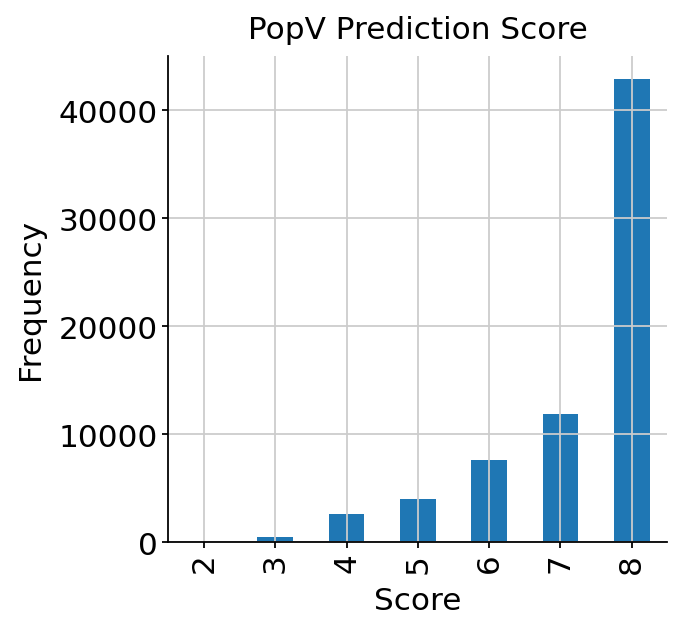

In [24]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_majority_vote_score")

<AxesSubplot:title={'center':'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

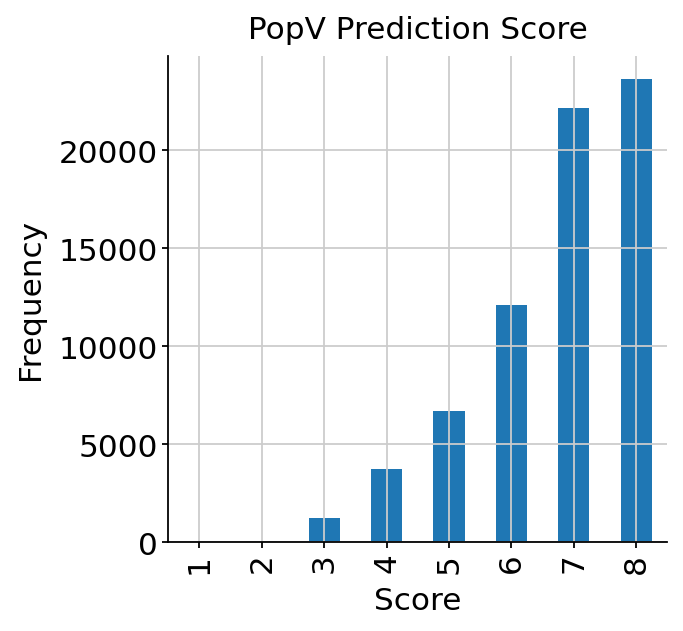

In [25]:
popv.visualization.prediction_score_bar_plot(adata, popv_prediction_score="popv_prediction_score")

In [26]:
%matplotlib inline

<AxesSubplot:ylabel='Mean Agreement'>

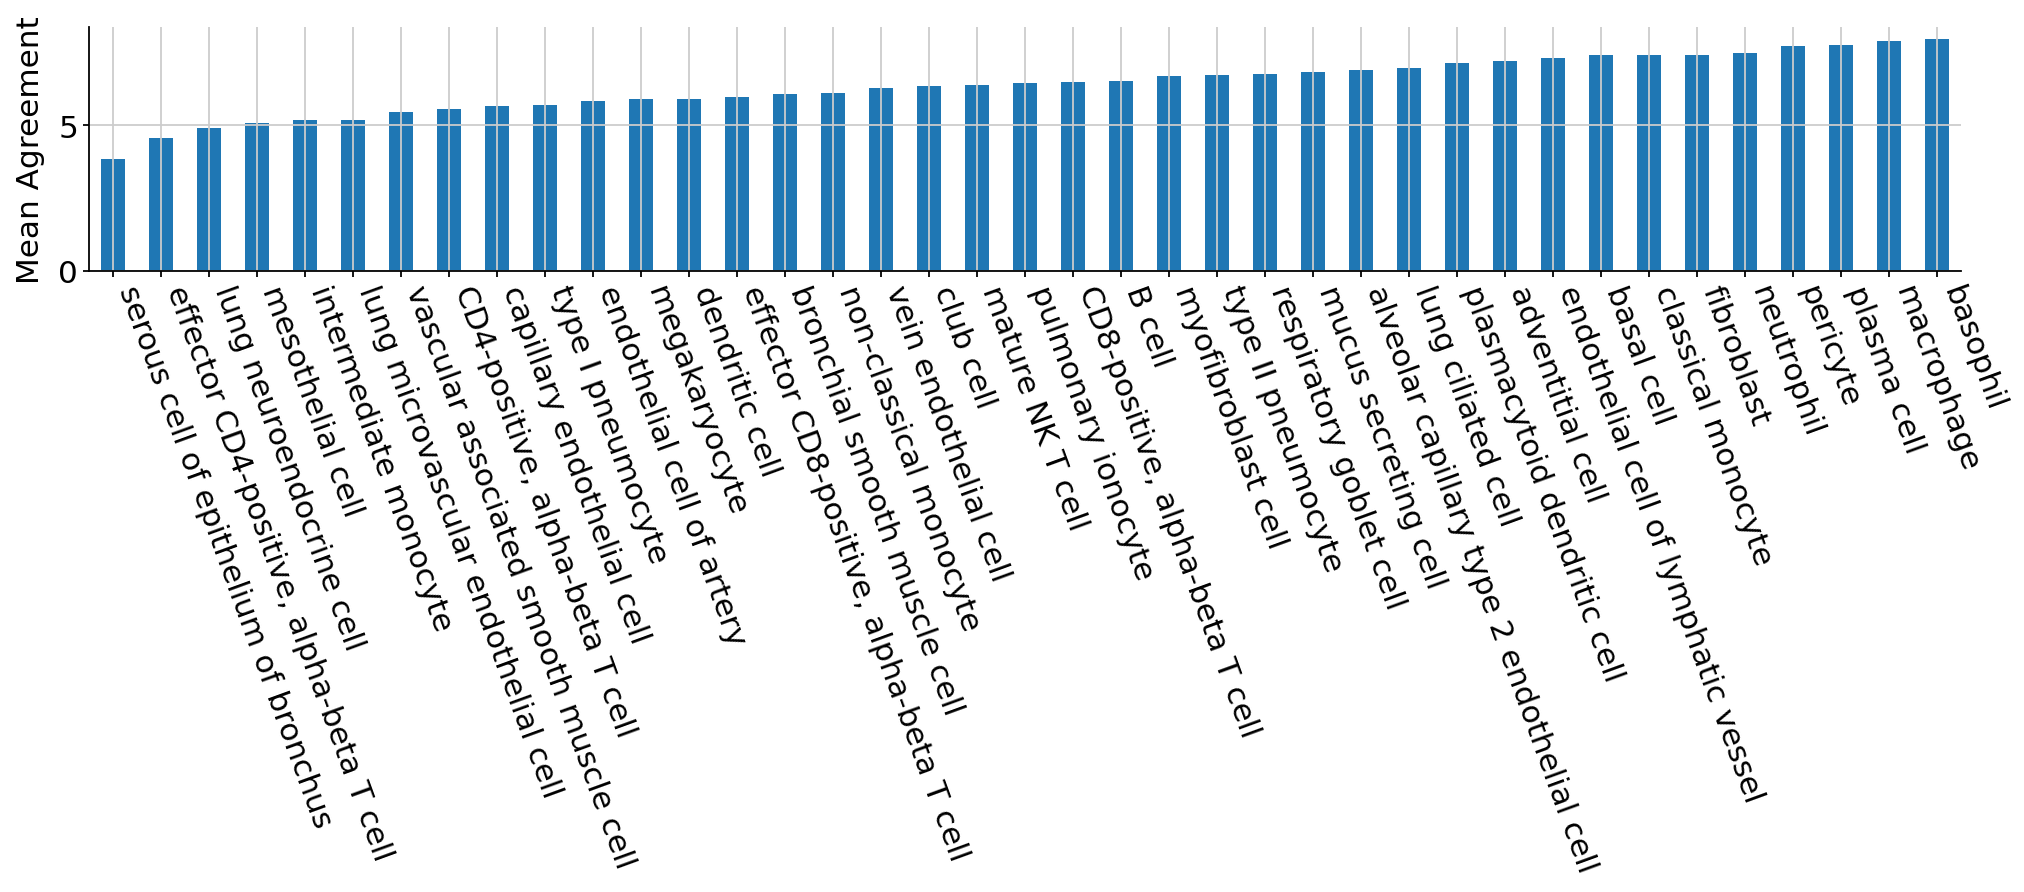

In [27]:
popv.visualization.agreement_score_bar_plot(adata, popv_prediction_key='cell_ontology_class')

<AxesSubplot:ylabel='Mean Agreement'>

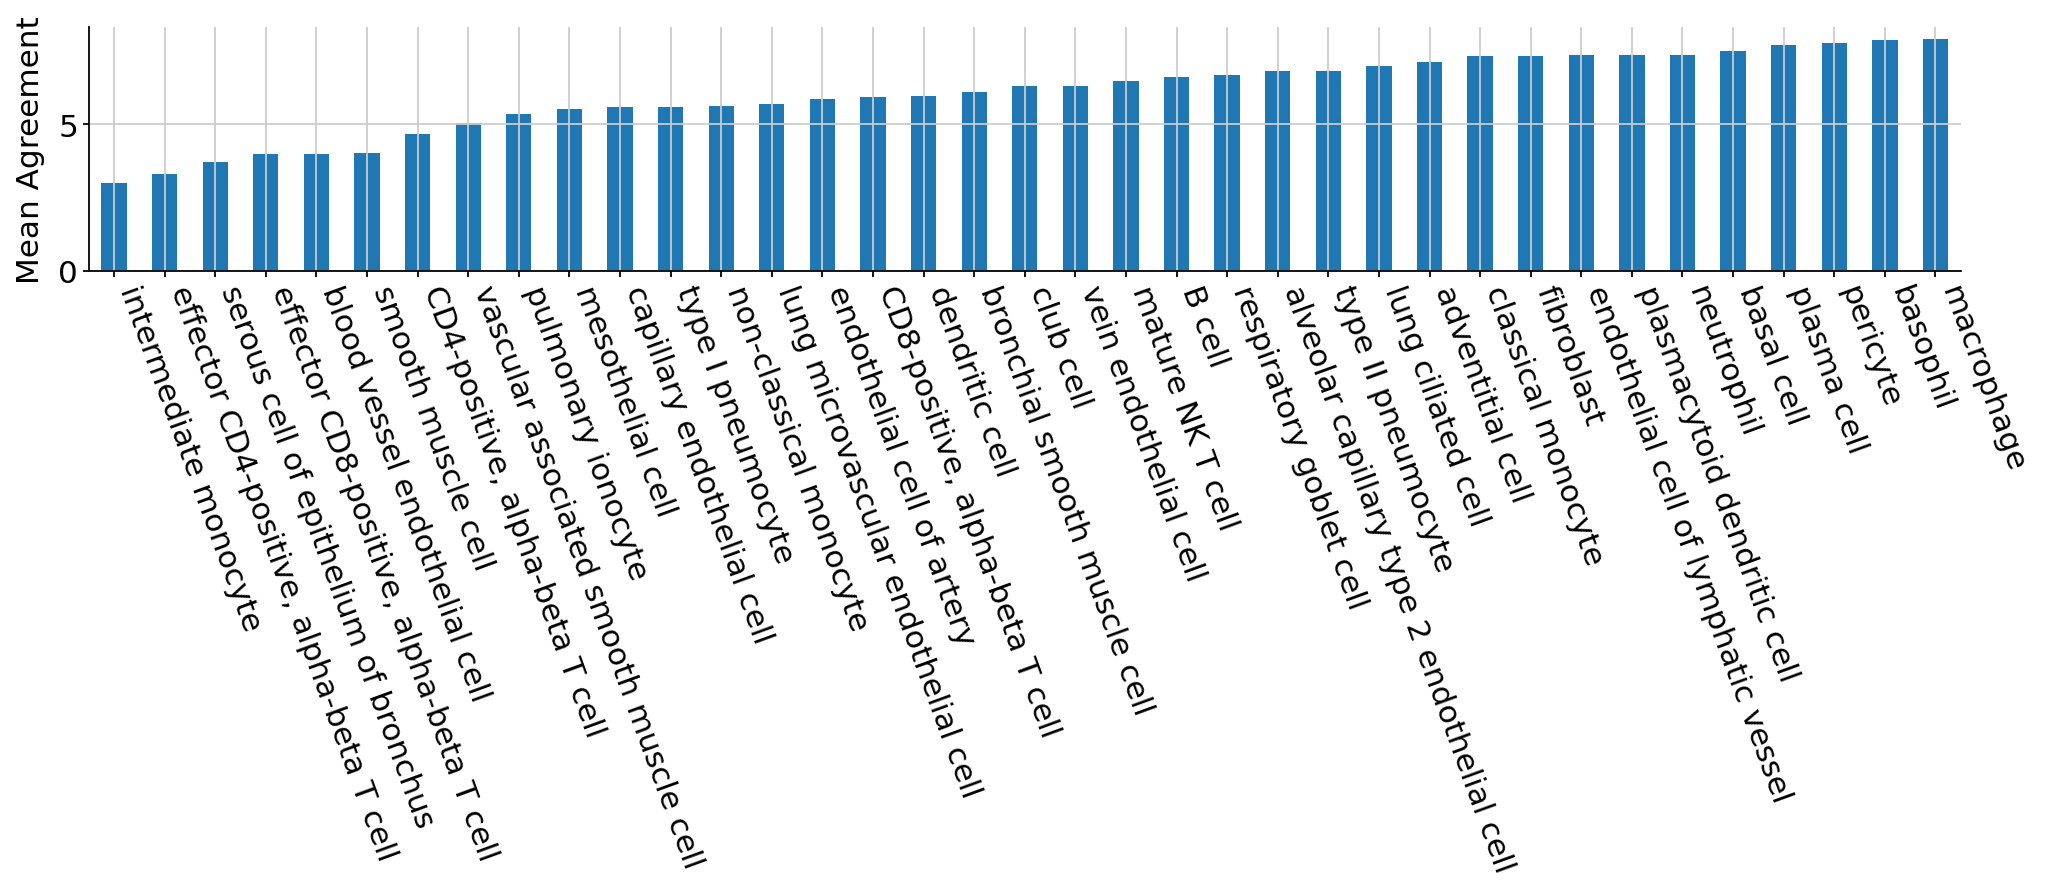

In [28]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<AxesSubplot:ylabel='log Celltype Abundance'>

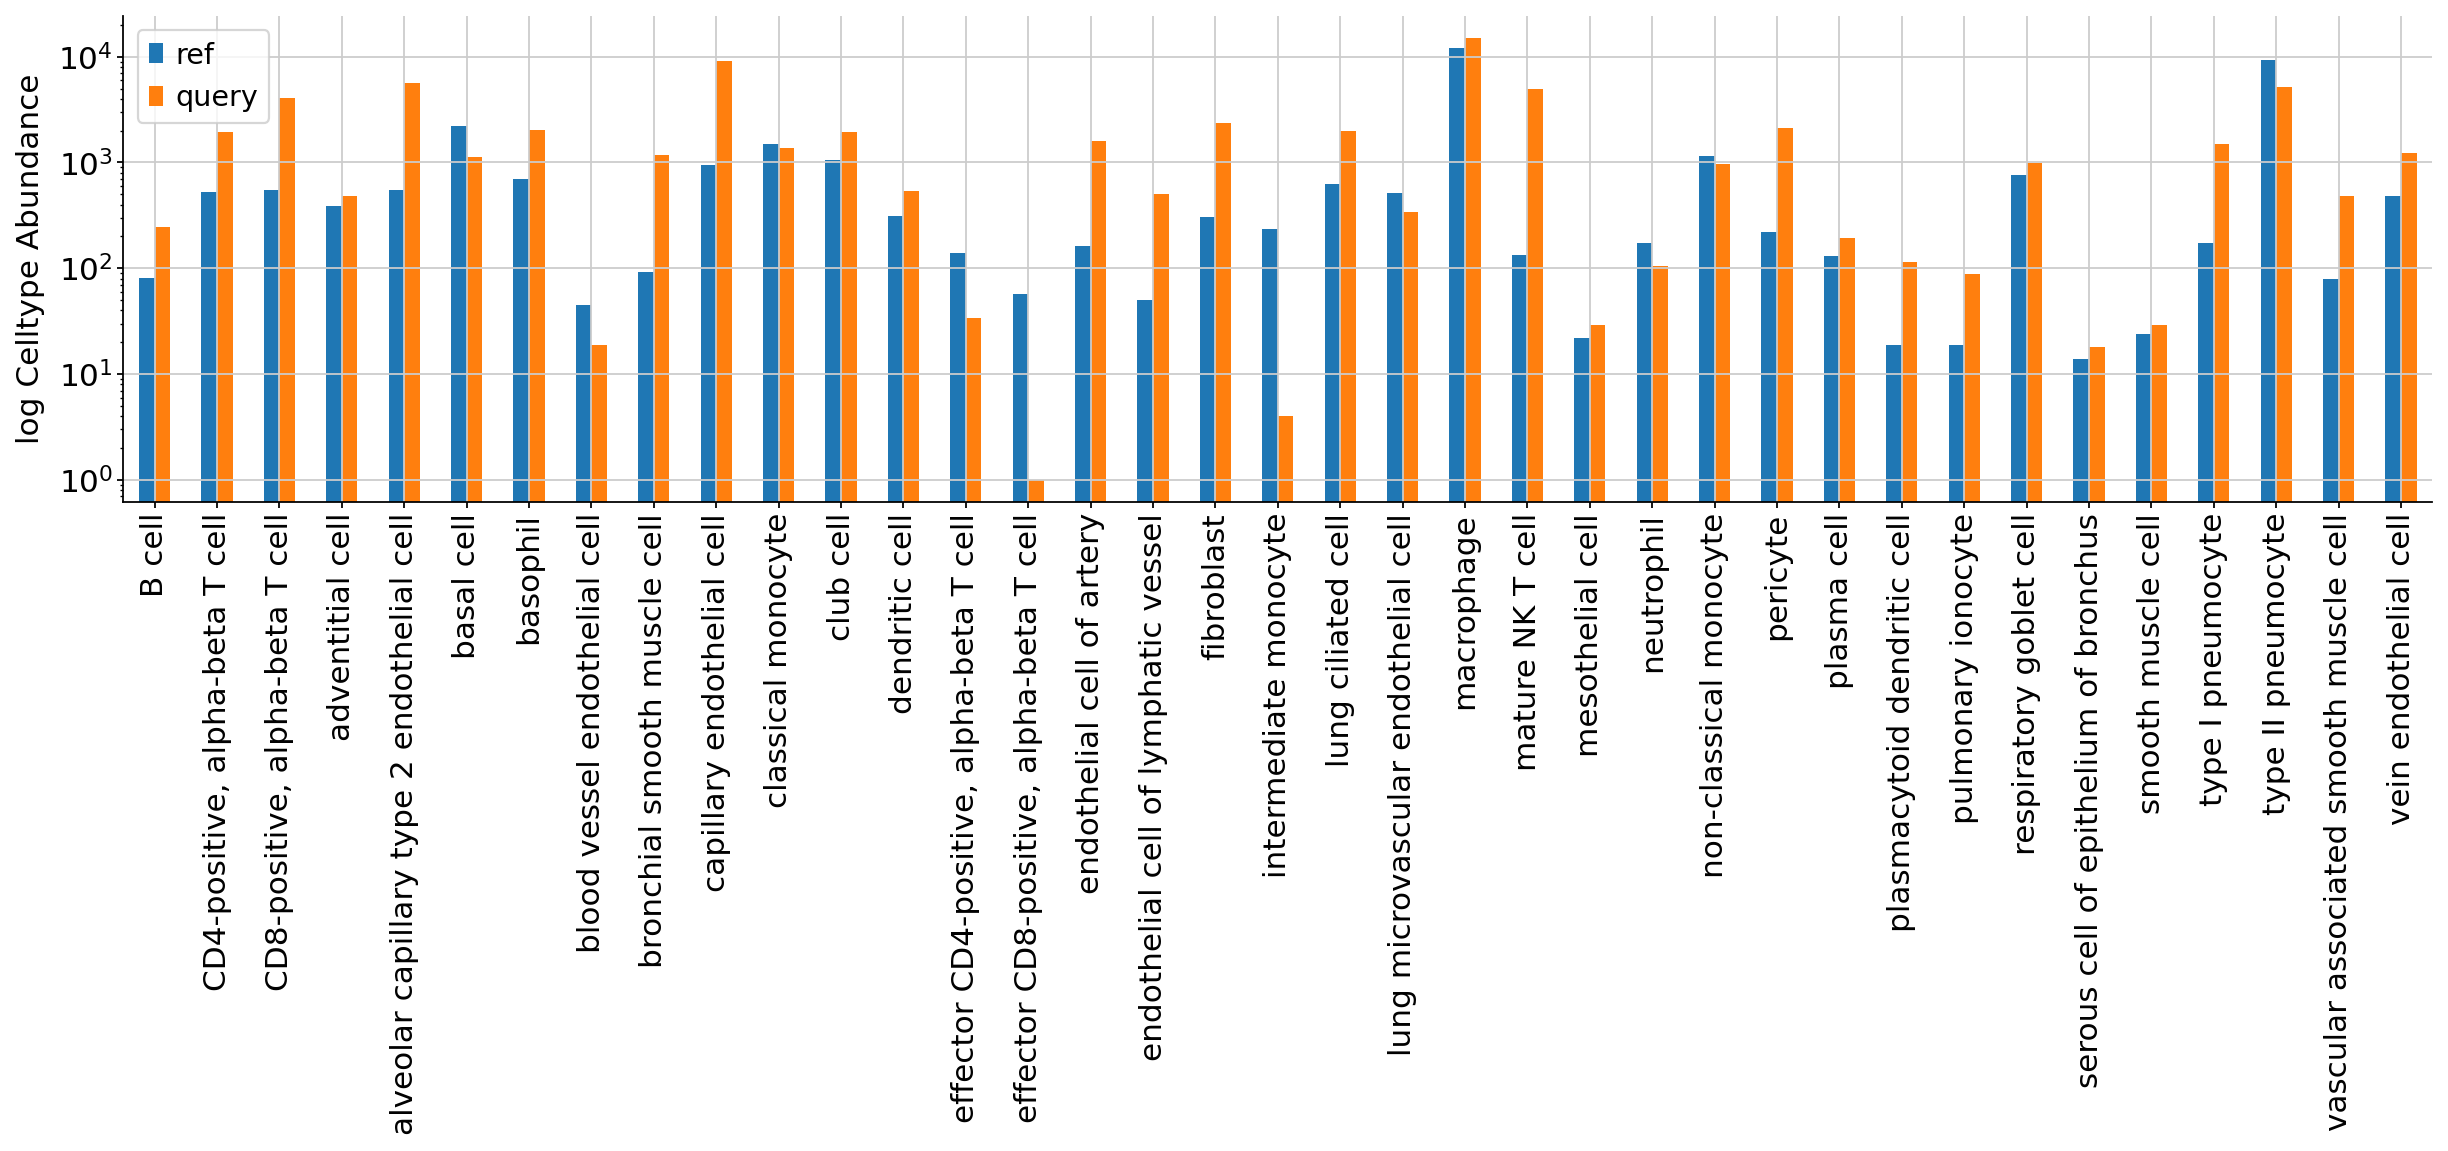

In [29]:
popv.visualization.celltype_ratio_bar_plot(adata)